In [1]:
# Reference: https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA


In [2]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m')
data = pd.read_csv('data/bbts/AirPassengers.csv', parse_dates=['Month'], 
                   index_col='Month', date_parser=dateparse)
print data.head()

            #Passengers
Month                  
1949-01-01          112
1949-02-01          118
1949-03-01          132
1949-04-01          129
1949-05-01          121


In [3]:
data.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name=u'Month', length=144, freq=None)

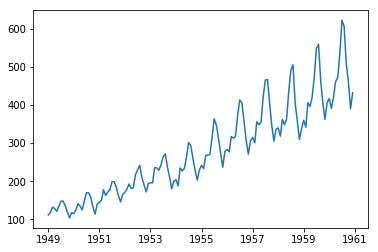

In [4]:
ts = data['#Passengers']
plt.plot(ts)

In [5]:
#1. Specific the index as a string constant:
ts['1949-01-01']

#2. Import the datetime library and use 'datetime' function:
ts[datetime(1949,1,1)]

112

In [6]:
ts['1949']

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
1949-06-01    135
1949-07-01    148
1949-08-01    148
1949-09-01    136
1949-10-01    119
1949-11-01    104
1949-12-01    118
Name: #Passengers, dtype: int64

In [7]:
def test_stationarity(timeseries, p=0.05):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print 'Results of Dickey-Fuller Test:'
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print dfoutput
    
    if dftest[1] > p:
        return 0
    else:
        return 1

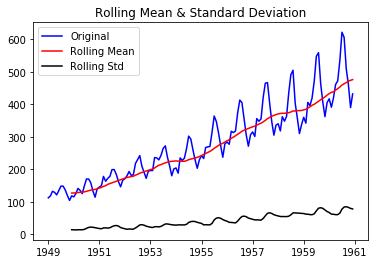

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (5%)             -2.884042
Critical Value (1%)             -3.481682
Critical Value (10%)            -2.578770
dtype: float64


0

In [8]:
t = test_stationarity(ts)
t

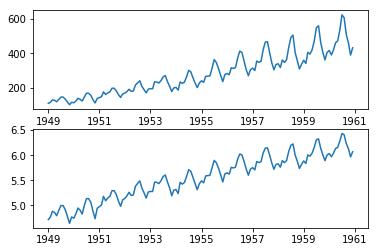

In [39]:
def take_log_ts(ts):
    ts_log = np.log(ts)
    plt.figure(1)
    plt.subplot(211)
    plt.plot(ts)
    plt.subplot(212)
    plt.plot(ts_log)
    return ts_log
ts_log = take_log_ts(ts)

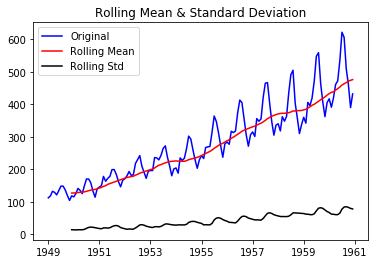

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (5%)             -2.884042
Critical Value (1%)             -3.481682
Critical Value (10%)            -2.578770
dtype: float64


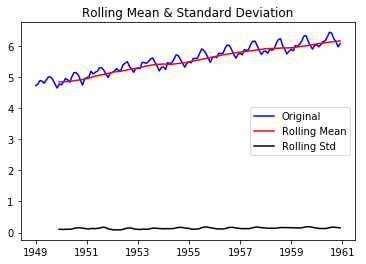

Results of Dickey-Fuller Test:
Test Statistic                  -1.717017
p-value                          0.422367
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (5%)             -2.884042
Critical Value (1%)             -3.481682
Critical Value (10%)            -2.578770
dtype: float64


0

In [40]:
test_stationarity(ts)
test_stationarity(ts_log)

In [41]:
def MA_diff(timeseries, periods=12):
    moving_avg = timeseries.rolling(periods).mean()
    ts_log_moving_avg_diff = timeseries - moving_avg
    ts_log_moving_avg_diff.dropna(inplace=True)
    plt.subplot(212)
    adftest = test_stationarity(ts_log_moving_avg_diff)
    return ts_log_moving_avg_diff, adftest

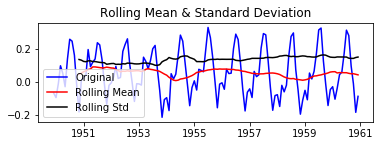

Results of Dickey-Fuller Test:
Test Statistic                  -3.162908
p-value                          0.022235
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value (5%)             -2.886151
Critical Value (1%)             -3.486535
Critical Value (10%)            -2.579896
dtype: float64


In [42]:
ts_log_moving_avg_diff, adftest = MA_diff(ts_log)

In [43]:
def expweighted_diff(timeseries, halflife=12):
    expwighted = timeseries.ewm(halflife)
    expwighted_avg = expwighted.mean()
    ts_expwighted_avg_diff = timeseries - expwighted_avg
    # ts_expwighted_avg_diff.dropna(inplace=True)
    adftest = test_stationarity(ts_expwighted_avg_diff)
    return ts_expwighted_avg_diff, adftest

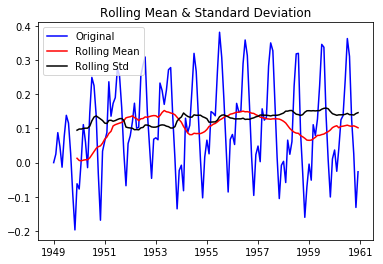

Results of Dickey-Fuller Test:
Test Statistic                  -3.566092
p-value                          0.006443
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (5%)             -2.884042
Critical Value (1%)             -3.481682
Critical Value (10%)            -2.578770
dtype: float64


In [44]:
ts_expwighted_avg_diff, adftest = expweighted_diff(ts_log)

In [45]:
def diff(ts, order=1, periods=1):
    if order != 0:
        for i in range(order):
            ts_diff = ts - ts.shift(periods=periods)
    return ts

def differencing(ts_log, periods=1):
    ### Differencing and testing the stationary
    ts_log_diff = diff(ts_log, order=1, periods=periods)
#     plt.plot(ts_log_diff)
    ts_log_diff.dropna(inplace=True)
    adftest = test_stationarity(ts_log_diff)
    return ts_log_diff, adftest

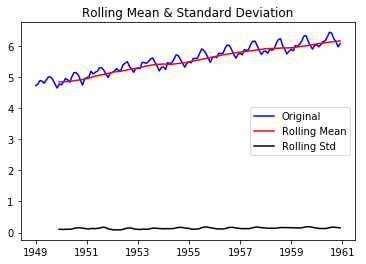

Results of Dickey-Fuller Test:
Test Statistic                  -1.717017
p-value                          0.422367
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (5%)             -2.884042
Critical Value (1%)             -3.481682
Critical Value (10%)            -2.578770
dtype: float64


In [33]:
ts_log_diff, adftest = differencing(ts_log)

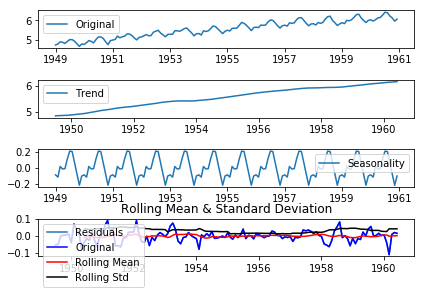

Results of Dickey-Fuller Test:
Test Statistic                -6.332387e+00
p-value                        2.885059e-08
#Lags Used                     9.000000e+00
Number of Observations Used    1.220000e+02
Critical Value (5%)           -2.885538e+00
Critical Value (1%)           -3.485122e+00
Critical Value (10%)          -2.579569e+00
dtype: float64


In [34]:
def decomposition_diff(timeseries):   
    decomposition = seasonal_decompose(timeseries)
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    plt.subplot(411)
    plt.plot(timeseries, label='Original')
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(seasonal,label='Seasonality')
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(residual, label='Residuals')
    plt.legend(loc='best')
    plt.tight_layout()
    
    ts_decompose = residual
    ts_decompose.dropna(inplace=True)
    adftest = test_stationarity(ts_decompose)
    return trend, seasonal, residual, adftest

trend, seasonal, residual, adftest = decomposition_diff(ts_log)

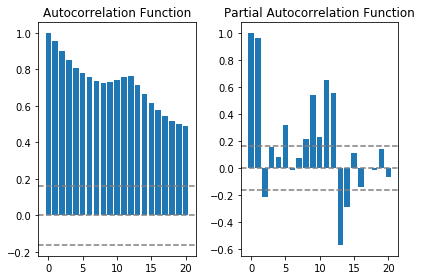

In [47]:
def acf_pacf(timeseries, nlags=20):
    lag_acf = acf(timeseries, nlags=nlags)
    lag_pacf = pacf(timeseries, nlags=nlags, method='ols')
    #Plot ACF: 
    plt.subplot(121) 
    plt.bar(range(len(lag_acf)), lag_acf)
    plt.axhline(y=0,linestyle='--',color='gray')
    plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
    plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
    plt.title('Autocorrelation Function')
    #Plot PACF:
    plt.subplot(122)
    plt.bar(range(len(lag_pacf)), lag_pacf)
    plt.axhline(y=0,linestyle='--',color='gray')
    plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
    plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
    plt.title('Partial Autocorrelation Function')
    plt.tight_layout()
    
    return lag_acf, lag_pacf

lag_acf, lag_pacf = acf_pacf(ts_log_diff)

/anaconda2/lib/python2.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


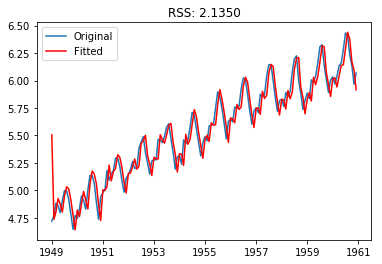

In [51]:
def build_ARIMA(timeseries, order=(1,0,1)):
    p,d,q = order
    model = ARIMA(timeseries, order=order)
    results = model.fit(disp=-1)  
    timeseries_diff = diff(timeseries, order=d)
    plt.plot(timeseries_diff, label='Original')
    plt.legend(loc='best')
    plt.plot(results.fittedvalues, color='red', label='Fitted')
    plt.legend(loc='best')
    RSS = sum((results.fittedvalues-timeseries_diff)**2)
    plt.title('RSS: %.4f'% RSS)
    return results, RSS
result, RSS = build_ARIMA(ts_log_diff, order=(2,0,0))